<h1><center><span style="color:red;">**IMPORTANT NOTICE**</span></center></h1>

Before submitting, **please**, make sure that your notebook runs **without errors** in Python 3.6
and **reproduces your solution as intended**, when you **Restart the Kernel and re-run the whole
notebook**!
<span style="color:red;">You will be severely penalized if you notebook does not run.</span>

Whereever applicable your solution will be graded based on the **plots**, generated by
**your code** on **TA's** computer.

<br/> <!--Intentionally left blank-->

# Home Assignment -- 5

Please, write your implementation within the designated blocks:
```python
...
### BEGIN Solution

# >>> your solution here <<<

### END Solution
...
```

Write your theoretical derivations within such blocks:
```markdown
**BEGIN Solution**

<!-- >>> your derivation here <<< -->

**END Solution**
```

## $\LaTeX$ in Jupyter
Jupyter has constantly improving $\LaTeX$ support. Below are the basic methods to
write **neat, tidy, and well typeset** equations in your notebooks:
* to write an **inline** equation use 
```markdown
$ you latex equation here $
```
* to write an equation, that is **displayed on a separate line** use 
```markdown
$$ you latex equation here $$
```
* to write a **block of equations** use 
```markdown
\begin{align}
    left-hand-side
        &= right-hand-side on line 1
        \\
        &= right-hand-side on line 2
        \\
        &= right-hand-side on the last line
\end{align}
```
The **ampersand** (`&`) aligns the equations horizontally and the **double backslash**
(`\\`) creates a new line.

<br/> <!--Intentionally left blank-->

<hr/> <!--Intentionally left blank-->

# Part 1 (19 pt.): Model selection and sensitivity analysis

<br/> <!--Intentionally left blank-->

## Task 1 (2 pt.): Information criteria

Assume that regression model is
$$y = \sum_{i=1}^k \beta_i x_i + \varepsilon,$$
and $\varepsilon$ is dictributed as normally: $\varepsilon \sim \mathcal{N}(0, \sigma^2)$, $\sigma^2$ is known.

Prove that the model with highest Akaike information criterion is the model with smallest Mallow's $C_p$.

**BEGIN Solution**

I will show that $$ - 2\mathcal{L}_J(\beta) + 2|J| \sim \frac{k}{\sigma^2}\hat{R}(J)$$

$$- 2\mathcal{L}_J(\beta) + 2|J| = -2\left( k\log \frac{1}{\sqrt{2\pi}\sigma} - \frac{1}{2\sigma^2}\sum_{i=1}^{k}(y_i - \beta_J^Tx_{i,J})^2\right) + 2|J|=\\=
-2\left(-\frac{k}{2}(\log(2\pi)+\log(\sigma^2) - \frac{1}{2\sigma^2}\sum_{i=1}^{k}(y_i - \beta_J^Tx_{i,J})^2 \right)+2|J|=\\=
k\left( \log(2\pi)+\log(\sigma^2) \right) + \frac{\sum_{i=1}^{k}(y_i - \beta_J^Tx_{i,J})^2}{\sigma^2} 2|J| =\\=
k \log(2\pi \sigma^2) + \frac{k}{\sigma^2}\left[\frac{\sum_{i=1}^{k}(y_i - \beta_J^Tx_{i,J})^2}{k} + \frac{2\sigma^2}{k}|J| \right] =\\=
k \log(2\pi \sigma^2) + \frac{k}{\sigma^2}\hat{R}(J)$$, where $$\frac{k}{\sigma^2} >0$$

$\Rightarrow \qquad \qquad \text{Highest AIC}(J) = \mathcal{L}_J - |J| \quad \Leftrightarrow\quad \text{Smallest C}_p = \hat{R}(J)$


**END Solution**

<br/> <!--Intentionally left blank-->

## Task 2 (17 pt.): Sensitivity analysis and optimization for rotating disk problem

In this tsk, you are proposed to solve a problem of optimization of a rotating disc. You will use approximation techniques, sensitivity analysis and optimization. For sensitivity analysis you are recommended to use SALib library (https://github.com/SALib/SALib), and scipy for optimization.

1. Parameters `r1,t1,r2,r3,t3,r4` are input variables that define a geometrical shape of a disk. Parameters `mass,smax,u2` are mass of a disk, maximal radial stress, and contact stress, respectively. **Those are the
target variables to predict (yes there are three regression targets).**
2. The `problem` Pythonic dict is used for SALib methods and defines bounds for parameters.

### Necessary imports

Run the following command in the next empty code cell.

```python
!pip install salib
```

Other imports

In [1]:
%matplotlib inline
from SALib.analyze import sobol as sobol_analyzer
from SALib.analyze import morris as morris_analyzer

from SALib.sample import saltelli as saltelli_sampler
from SALib.sample import morris as morris_sampler

from scipy.optimize import minimize

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV

### Define problem

Problem is defined as a simple Pythonic dict, where you should number of input variables,
bounds for each input variable and their names. This will be helpful for sensitivity analysis.
Note, that bounds defined here are true for **standardized data**.

In [2]:
problem = {
    'num_vars': 6,
    'names': data.columns.values[:6],
    'bounds': np.array([[-1.7321, 1.7321],
                        [-1.7321, 1.7321],
                        [-1.7321, 1.7321],
                        [-1.7321, 1.7321],
                        [-1.7321, 1.7321],
                        [-1.7321, 1.7321]]),
    'groups': None
    }

NameError: name 'data' is not defined

<br/> <!--Intentionally left blank-->

### Task 2.1 (7 pt.): Surrogate modelling

The actual dependency is not given, only a data set of inputs and outputs.
Surrogate modelling is an approach that allows to construct approximations of the real dependecy, and use them for optimization and modelling.
To perform sensitivity analysis and optimization we are going to use a regression model.

Your tasks:

* Load the data set from `data/doe_100.csv`.
* Build several regression models using different techniques: Gaussian Process Regression, Kernel Ridge regression, SVR.
* Perform k-fold cross-validation for each model and choose the best.

The most accurate models will be used in **all subsequent excersices**.

<span style="color:green">**NOTE**</span> sklearn has a convenient GP implementation.

```python
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import My, Favourite, Kernels, ...
```

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings

In [4]:
random_state = 42
k_fold = KFold(n_splits=5, random_state=random_state)
standard_scaler = StandardScaler()
data = pd.read_csv('data/doe_100.csv')
columns = data.columns
y_mass = data['mass']
y_smax = data['smax']
y_u2 = data['u2']
X = data.drop(['mass', 'smax','u2'], axis=1)

X = standard_scaler.fit_transform(X)
X = pd.DataFrame(X, columns = columns[:6])
X.head()

,r1,t1,r2,r3,t3,r4
0,-1.541602,-0.952676,-0.294463,-0.017321,0.883390,-1.056604
1,-0.744819,-0.606248,0.086607,0.640891,0.918033,-1.368389
2,-0.779462,-0.398392,0.952676,-0.294463,-0.190535,-0.883390
3,1.195175,-1.680173,-1.021961,-0.190535,0.329106,-1.506960
4,-0.606248,0.536963,0.814105,-1.125889,1.229818,-0.675534


#### Mass Target

In [5]:
#GPR RBF kernel
gpr = GaussianProcessRegressor()
gaussian_grid = {
    'random_state':[random_state],
    'kernel':[RBF(0.1*ls) for ls in np.arange(1, 20)] + [RBF(0.1*ls) + WhiteKernel() for ls in np.arange(1, 20)]
}
warnings.filterwarnings("ignore", message="fmin_l_bfgs_b terminated "+
                        "abnormally with the  state",category=UserWarning)
reg=GridSearchCV(gpr,gaussian_grid, n_jobs=-1,cv=k_fold,scoring='neg_mean_squared_error')
reg.fit(X, y_mass)
print ('GPR RBF best params',reg.best_params_,'\n\t with best score:', -reg.best_score_)
mass_gpr_1 = reg.best_estimator_

#GPR Matern kernel
gpr = GaussianProcessRegressor()
matern_grid = {
    'random_state':[random_state],
    'kernel':[Matern(0.1*ls) for ls in np.arange(1, 20)] + [Matern(0.1*ls) + WhiteKernel() for ls in np.arange(1, 20)]
}
warnings.filterwarnings("ignore", message="fmin_l_bfgs_b terminated "+
                        "abnormally with the  state",category=UserWarning)
reg=GridSearchCV(gpr,matern_grid, n_jobs=-1,cv=k_fold,scoring='neg_mean_squared_error')
reg.fit(X, y_mass)
print ('GPR Matern best params',reg.best_params_,'\n\t with best score:', -reg.best_score_)
mass_gpr_2= reg.best_estimator_

#Ridge regression with RBF Kernel
rr = KernelRidge()
params = {
    "kernel": ['rbf'],
    "alpha": [1e0, 0.1, 1e-2, 1e-3],
    "gamma": np.logspace(0,-4,5)
}
reg=GridSearchCV(rr,params, n_jobs=-1,cv=k_fold,scoring='neg_mean_squared_error')
reg.fit(X, y_mass)
print ('Ridge regression RBF best params',reg.best_params_,'\n\t with best score:', -reg.best_score_)
mass_rr = reg.best_estimator_

#Ridge regression with RBF Kernel
svr = SVR()
params = {
    "kernel": ['rbf'],
    "C": [1e0, 1e1, 1e2, 1e3],
    "gamma": np.logspace(-2, 2, 5)}
reg=GridSearchCV(svr,params, n_jobs=-1,cv=k_fold,scoring='neg_mean_squared_error')
reg.fit(X, y_mass)
print ('Ridge regression RBF best params',reg.best_params_,'\n\t with best score:', -reg.best_score_)
mass_svr = reg.best_estimator_

GPR RBF best params {'kernel': RBF(length_scale=1.5), 'random_state': 42} 
	 with best score: 0.4516724792130588
GPR Matern best params {'kernel': Matern(length_scale=1.8, nu=1.5), 'random_state': 42} 
	 with best score: 0.5455974460269395
Ridge regression RBF best params {'alpha': 0.001, 'gamma': 0.01, 'kernel': 'rbf'} 
	 with best score: 0.0625642250039231
Ridge regression RBF best params {'C': 1000.0, 'gamma': 0.01, 'kernel': 'rbf'} 
	 with best score: 0.03997231284173243


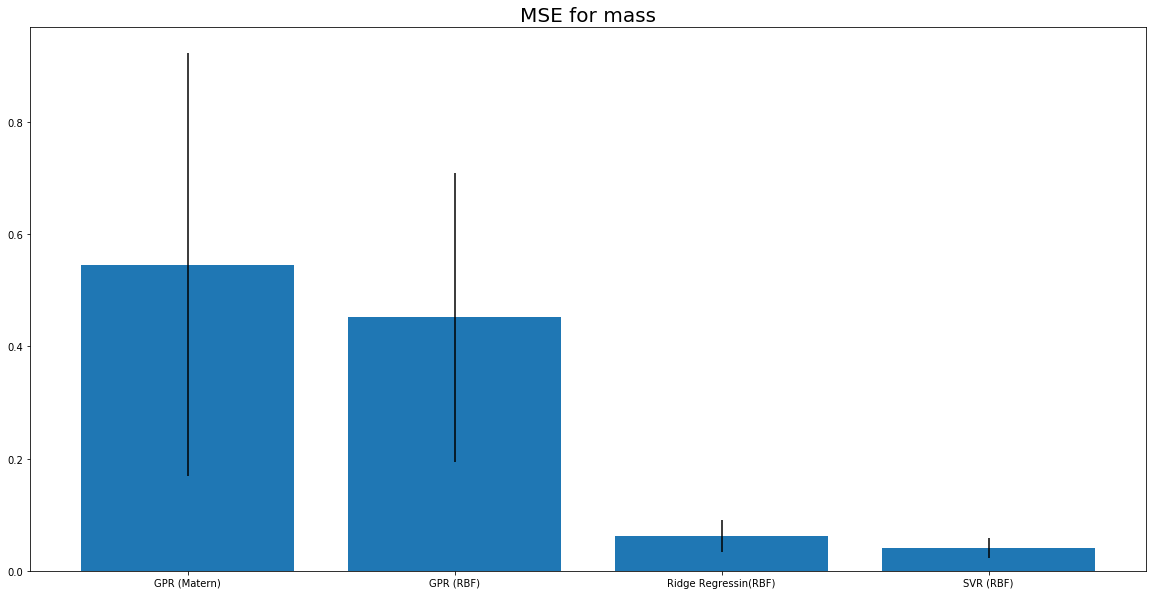

In [6]:
models = [mass_gpr_1, mass_gpr_2, mass_rr, mass_svr]
names = ['GPR (RBF)', 'GPR (Matern)', 'Ridge Regressin(RBF)', 'SVR (RBF)']
scores_mass = []
std_mass = []
plt.figure(figsize=(20,10))
for algo in models:
    score = cross_val_score(algo, X, y_mass, cv = k_fold, scoring='neg_mean_squared_error')
    scores_mass.append(-score.mean())
    std_mass.append(score.std())
plt.bar(names,scores_mass, yerr = std_mass)
plt.title('MSE for mass',size=20)
plt.show()

#### Smax target

In [7]:
#GPR RBF kernel
gpr = GaussianProcessRegressor()
gaussian_grid = {
    'random_state':[random_state],
    'kernel':[RBF(ls) for ls in np.arange(1, 20)] + [RBF(ls) + WhiteKernel() for ls in np.arange(1, 20)]
}
warnings.filterwarnings("ignore", message="fmin_l_bfgs_b terminated "+
                        "abnormally with the  state",category=UserWarning)
reg=GridSearchCV(gpr,gaussian_grid, n_jobs=-1,cv=k_fold,scoring='neg_mean_squared_error')
reg.fit(X, y_smax)
print ('GPR RBF best params',reg.best_params_,'\n\t with best score:', -reg.best_score_)
smax_gpr_1 = reg.best_estimator_

#GPR Matern kernel
gpr = GaussianProcessRegressor()
matern_grid = {
    'random_state':[random_state],
    'kernel':[Matern(0.1*ls) for ls in np.arange(1, 20)] + [Matern(0.1*ls) + WhiteKernel() for ls in np.arange(1, 20)]
}
warnings.filterwarnings("ignore", message="fmin_l_bfgs_b terminated "+
                        "abnormally with the  state",category=UserWarning)
reg=GridSearchCV(gpr,matern_grid, n_jobs=-1,cv=k_fold,scoring='neg_mean_squared_error')
reg.fit(X, y_smax)
print ('GPR Matern best params',reg.best_params_,'\n\t with best score:', -reg.best_score_)
smax_gpr_2= reg.best_estimator_

#Ridge regression with RBF Kernel
rr = KernelRidge()
params = {
    "kernel": ['rbf'],
    "alpha": [1e0, 0.1, 1e-2, 1e-3],
    "gamma": np.logspace(0,-4,5)
}
reg=GridSearchCV(rr,params, n_jobs=-1,cv=k_fold,scoring='neg_mean_squared_error')
reg.fit(X, y_smax)
print ('Ridge regression RBF best params',reg.best_params_,'\n\t with best score:', -reg.best_score_)
smax_rr = reg.best_estimator_

#Ridge regression with RBF Kernel
svr = SVR()
params = {
    "kernel": ['rbf'],
    "C": [1e0, 1e1, 1e2, 1e3],
    "gamma": np.logspace(-2, 2, 5)}
reg=GridSearchCV(svr,params, n_jobs=-1,cv=k_fold,scoring='neg_mean_squared_error')
reg.fit(X, y_smax)
print ('Ridge regression RBF best params',reg.best_params_,'\n\t with best score:', -reg.best_score_)
smax_svr = reg.best_estimator_

GPR RBF best params {'kernel': RBF(length_scale=2), 'random_state': 42} 
	 with best score: 21961.838005836456
GPR Matern best params {'kernel': Matern(length_scale=1.1, nu=1.5), 'random_state': 42} 
	 with best score: 11143.34068731891
Ridge regression RBF best params {'alpha': 0.001, 'gamma': 0.01, 'kernel': 'rbf'} 
	 with best score: 4284.166107606344
Ridge regression RBF best params {'C': 1000.0, 'gamma': 0.1, 'kernel': 'rbf'} 
	 with best score: 7197.919371049281


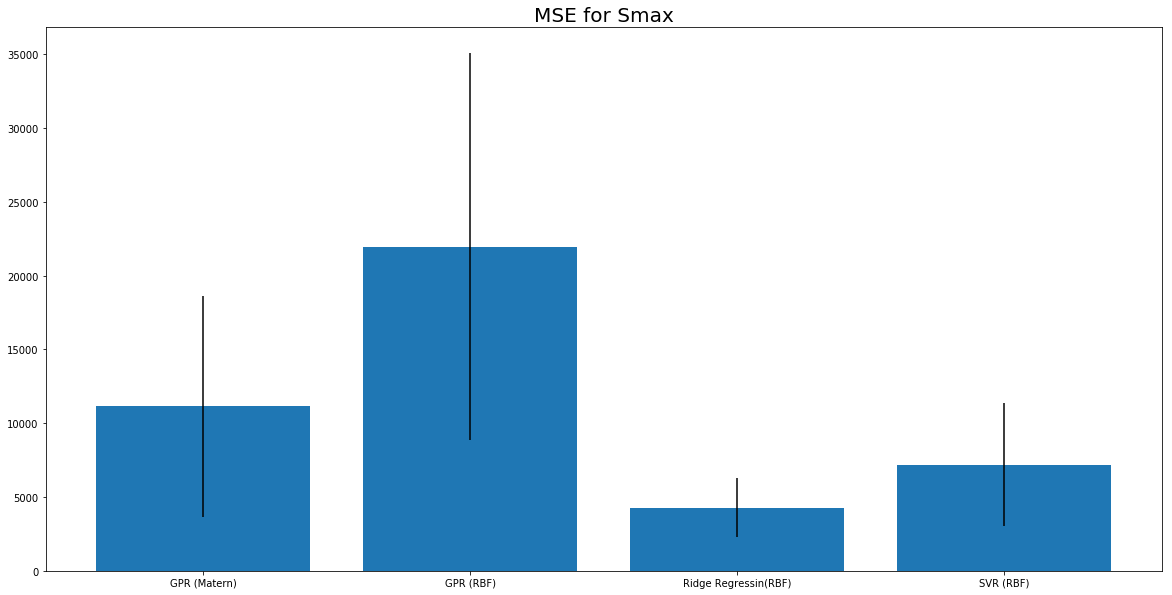

In [8]:
models = [smax_gpr_1, smax_gpr_2, smax_rr, smax_svr]
names = ['GPR (RBF)', 'GPR (Matern)', 'Ridge Regressin(RBF)', 'SVR (RBF)']
scores_mass = []
std_mass = []
plt.figure(figsize=(20,10))
for algo in models:
    score = cross_val_score(algo, X, y_smax, cv = k_fold, scoring='neg_mean_squared_error')
    scores_mass.append(-score.mean())
    std_mass.append(score.std())
plt.bar(names,scores_mass, yerr = std_mass)
plt.title('MSE for Smax',size=20)
plt.show()

#### U2 target

In [9]:
#GPR RBF kernel
gpr = GaussianProcessRegressor()
gaussian_grid = {
    'random_state':[random_state],
    'kernel':[RBF(0.1*ls) for ls in np.arange(1, 20)] + [RBF(0.1*ls) + WhiteKernel() for ls in np.arange(1, 20)]
}
warnings.filterwarnings("ignore", message="fmin_l_bfgs_b terminated "+
                        "abnormally with the  state",category=UserWarning)
reg=GridSearchCV(gpr,gaussian_grid, n_jobs=-1,cv=k_fold,scoring='neg_mean_squared_error')
reg.fit(X, y_u2)
print ('GPR RBF best params',reg.best_params_,'\n\t with best score:', -reg.best_score_)
u2_gpr_1 = reg.best_estimator_

#GPR Matern kernel
gpr = GaussianProcessRegressor()
matern_grid = {
    'random_state':[random_state],
    'kernel':[Matern(0.1*ls) for ls in np.arange(1, 20)] + [Matern(0.1*ls) + WhiteKernel() for ls in np.arange(1, 20)]
}
warnings.filterwarnings("ignore", message="fmin_l_bfgs_b terminated "+
                        "abnormally with the  state",category=UserWarning)
reg=GridSearchCV(gpr,matern_grid, n_jobs=-1,cv=k_fold,scoring='neg_mean_squared_error')
reg.fit(X, y_u2)
print ('GPR Matern best params',reg.best_params_,'\n\t with best score:', -reg.best_score_)
u2_gpr_2= reg.best_estimator_

#Ridge regression with RBF Kernel
rr = KernelRidge()
params = {
    "kernel": ['rbf'],
    "alpha": [1e0, 0.1, 1e-2, 1e-3],
    "gamma": np.logspace(0,-4,5)
}
reg=GridSearchCV(rr,params, n_jobs=-1,cv=k_fold,scoring='neg_mean_squared_error')
reg.fit(X, y_u2)
print ('Ridge regression RBF best params',reg.best_params_,'\n\t with best score:', -reg.best_score_)
u2_rr = reg.best_estimator_

#Ridge regression with RBF Kernel
svr = SVR()
params = {
    "kernel": ['rbf'],
    "C": [1e-1,1e0, 1e1, 1e2, 1e3],
    "gamma": np.logspace(-2, 2, 5)}
reg=GridSearchCV(svr,params, n_jobs=-1,cv=k_fold,scoring='neg_mean_squared_error')
reg.fit(X, y_u2)
print ('Ridge regression RBF best params',reg.best_params_,'\n\t with best score:', -reg.best_score_)
u2_svr = reg.best_estimator_

GPR RBF best params {'kernel': RBF(length_scale=1.5) + WhiteKernel(noise_level=1), 'random_state': 42} 
	 with best score: 0.00030900868886055296
GPR Matern best params {'kernel': Matern(length_scale=1.2, nu=1.5) + WhiteKernel(noise_level=1), 'random_state': 42} 
	 with best score: 0.00038334528270624903
Ridge regression RBF best params {'alpha': 0.001, 'gamma': 0.01, 'kernel': 'rbf'} 
	 with best score: 0.00038086868698371517
Ridge regression RBF best params {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'} 
	 with best score: 0.005707819834331665


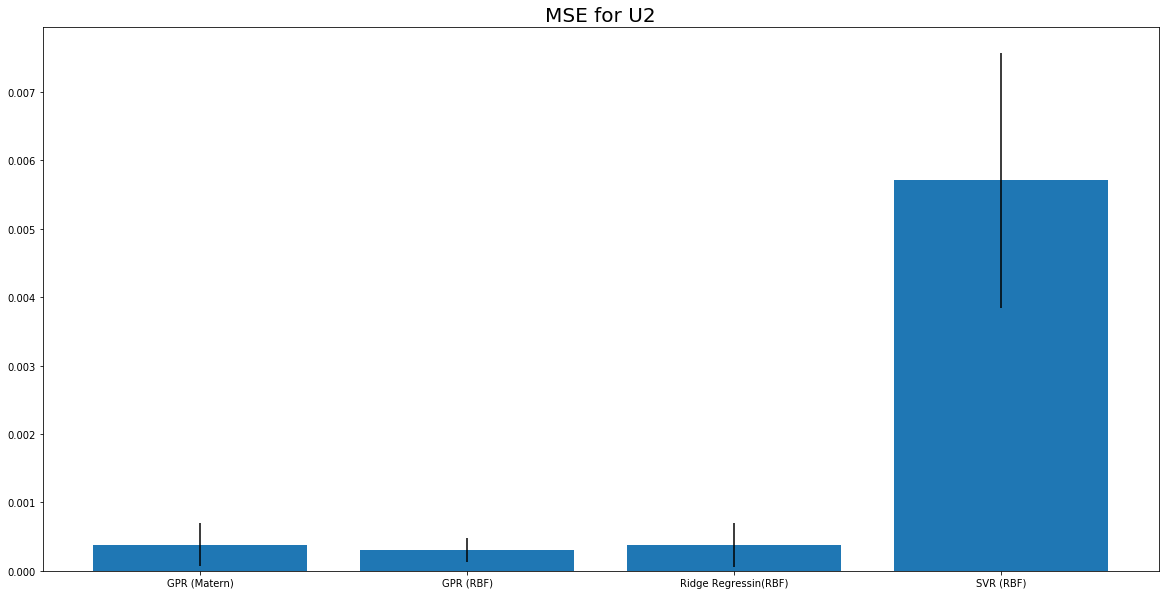

In [27]:
models = [u2_gpr_1, u2_gpr_2, u2_rr, u2_svr]
names = ['GPR (RBF)', 'GPR (Matern)', 'Ridge Regressin(RBF)', 'SVR (RBF)']
scores_mass = []
std_mass = []
plt.figure(figsize=(20,10))
for algo in models:
    score = cross_val_score(algo, X, y_u2, cv = k_fold, scoring='neg_mean_squared_error')
    scores_mass.append(-score.mean())
    std_mass.append(score.std())
plt.bar(names,scores_mass, yerr = std_mass)
plt.title('MSE for U2',size=20)
plt.show()

for Mass: <b>SVR</b>.

for Smax: <b>Ridge Regression</b>.

for U2: <b>GPR (RBF)</b>.

In [11]:
score = cross_val_score(mass_svr, X, y_mass, cv = k_fold, scoring='neg_mean_squared_error')
print ('Mass:', -score.mean().round(5),'+/-', score.std().round(3))
score = cross_val_score(smax_rr, X, y_smax, cv = k_fold, scoring='neg_mean_squared_error')
print ('Smax:', -score.mean().round(5),'+/-', score.std().round(3))
score = cross_val_score(u2_gpr_1, X, y_u2, cv = k_fold, scoring='neg_mean_squared_error')
print ('  U2:', -score.mean().round(6),'+/-', score.std().round(5))

Mass: 0.03997 +/- 0.018
Smax: 4284.16611 +/- 1986.835
  U2: 0.000309 +/- 0.00017


### Task 2.2 (6 pt.): Sensitivity analysis

SALib is a python library for sensitivity analysis.

It implements some popular global sensitivity analysis methods: 
* Morris method - that may be thought of as crude estimation of average absolute value of partial derivative. 
* Sobol indicies - that show portion of variance in the output that is explained by input.

Each method takes **x** and **y** samples as input. But the samples must be properly generated.
There are special functions in SALib library to do exactly that.

Using the **best model per target** your task is to

* calculate Sobol indices:
    * Generate **x** and **y** samples using Saltelli’s extension of the Sobol sequence
    * Calculate Sobol indices using obtained samples
* calculate screening indices
    * Generate **x** and **y** samples for Morris method
    * Apply Morris method to generated samples to obtain screening indices


* Using your judgement and based on the analysis results choose variables have the most influence on the output.

**NOTE** Make sure to use the *same sample* for all three targets.

In [12]:
X.head()

,r1,t1,r2,r3,t3,r4
0,-1.541602,-0.952676,-0.294463,-0.017321,0.883390,-1.056604
1,-0.744819,-0.606248,0.086607,0.640891,0.918033,-1.368389
2,-0.779462,-0.398392,0.952676,-0.294463,-0.190535,-0.883390
3,1.195175,-1.680173,-1.021961,-0.190535,0.329106,-1.506960
4,-0.606248,0.536963,0.814105,-1.125889,1.229818,-0.675534


In [13]:
problem = {
    'num_vars': 6,
    'names': X.columns.values[:6],
    'bounds': np.array([[-1.7321, 1.7321],
                        [-1.7321, 1.7321],
                        [-1.7321, 1.7321],
                        [-1.7321, 1.7321],
                        [-1.7321, 1.7321],
                        [-1.7321, 1.7321]]),
    'groups': None
    }

#### Sobol indices (Saltelli simpler): 

In [14]:
### BEGIN Solution
import matplotlib.pyplot as plt
import seaborn as sns
# >>> your solution here <<<
reg_mass = mass_svr
reg_smax = smax_rr
reg_u2 = u2_gpr_1

reg_mass.fit(X,y_mass)
reg_smax.fit(X,y_smax)
reg_u2.fit(X, y_u2)


model_input = saltelli_sampler.sample(problem, N=1000)
model_output_mass =  reg_mass.predict(model_input)
model_output_smax =  reg_smax.predict(model_input)
model_output_u2 =  reg_u2.predict(model_input)
SI_mass = sobol_analyzer.analyze(problem, model_output_mass)
SI_smax = sobol_analyzer.analyze(problem, model_output_smax)
SI_u2 = sobol_analyzer.analyze(problem, model_output_u2)

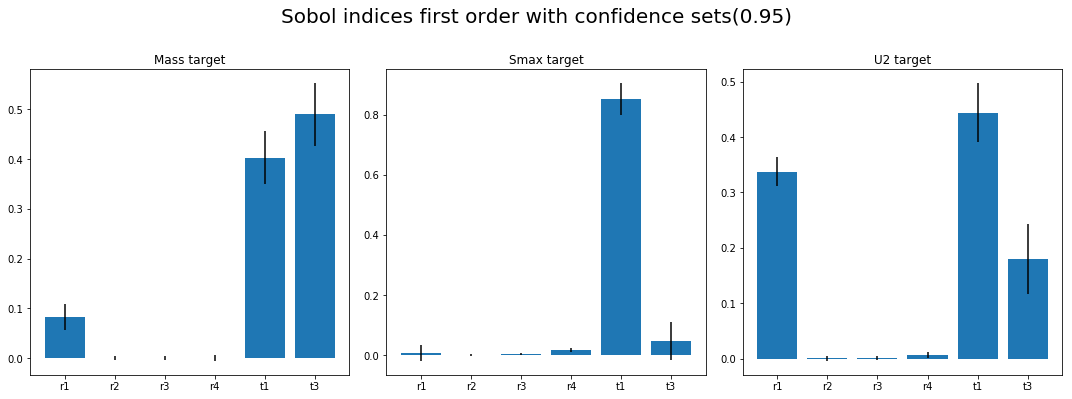

In [15]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize = (15,5))
plt.suptitle('Sobol indices first order with confidence sets(0.95)', fontsize=20, y=1.1)
ax1.bar(problem['names'], SI_mass['S1'],yerr=SI_mass['S1_conf'])
ax2.bar(problem['names'], SI_smax['S1'],yerr=SI_mass['S1_conf'])
ax3.bar(problem['names'], SI_u2['S1'],yerr=SI_mass['S1_conf'])
ax1.set_title('Mass target')
ax2.set_title('Smax target')
ax3.set_title('U2 target')
plt.tight_layout()
plt.show()

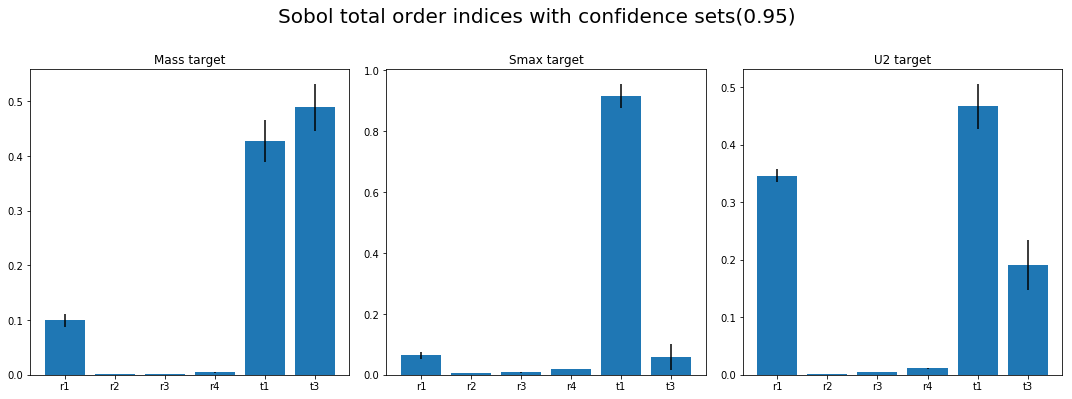

In [16]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize = (15,5))
plt.suptitle('Sobol total order indices with confidence sets(0.95)', fontsize=20, y=1.1)
ax1.bar(problem['names'], SI_mass['ST'],yerr=SI_mass['ST_conf'])
ax2.bar(problem['names'], SI_smax['ST'],yerr=SI_mass['ST_conf'])
ax3.bar(problem['names'], SI_u2['ST'],yerr=SI_mass['ST_conf'])
ax1.set_title('Mass target')
ax2.set_title('Smax target')
ax3.set_title('U2 target')
plt.tight_layout()
plt.show()

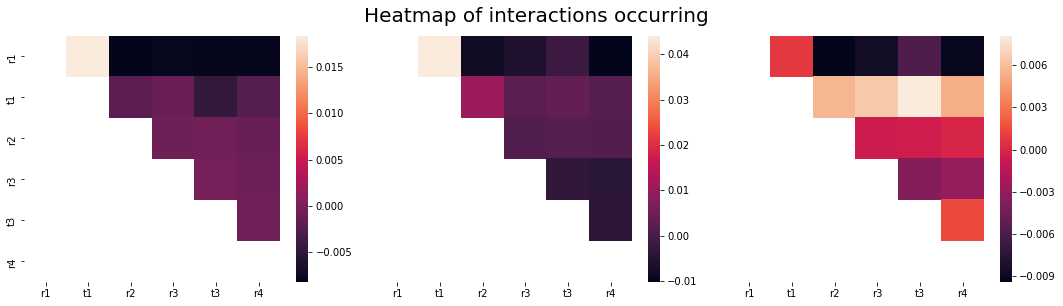

In [17]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize = (15,4))
plt.suptitle('Heatmap of interactions occurring', fontsize=20, y=1.05)
sns.heatmap(SI_mass['S2'], ax = ax1,xticklabels=problem['names'], yticklabels=problem['names'])
sns.heatmap(SI_smax['S2'], ax = ax2,xticklabels=problem['names'], yticklabels=False)
sns.heatmap(SI_u2['S2'], ax = ax3,xticklabels=problem['names'], yticklabels=False)
plt.tight_layout()
plt.show()

<br/> <!--Intentionally left blank-->

#### Morris indices:

In [18]:
model_input = morris_sampler.sample(problem, N=1000, num_levels=4, grid_jump=2)
model_output_mass =  reg_mass.predict(model_input)
model_output_smax =  reg_smax.predict(model_input)
model_output_u2 =  reg_u2.predict(model_input)
MI_mass = morris_analyzer.analyze(problem,model_input, model_output_mass)
MI_smax = morris_analyzer.analyze(problem, model_input,model_output_smax)
MI_u2 = morris_analyzer.analyze(problem, model_input,model_output_u2)

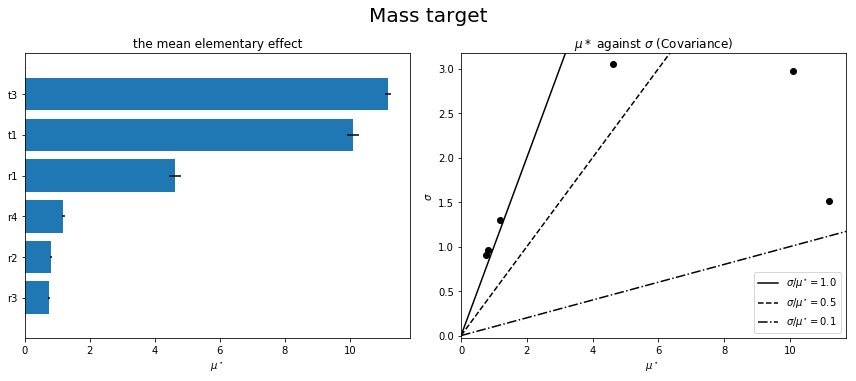

In [19]:
from SALib.plotting.morris import horizontal_bar_plot, covariance_plot

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5))
plt.suptitle('Mass target', fontsize=20, y=1.05)
horizontal_bar_plot(ax1, MI_mass,{}, sortby='mu_star')
covariance_plot(ax2, MI_mass, {})
ax1.set_title('the mean elementary effect')
ax2.set_title('$\mu*$ against $\sigma$ (Covariance)')
plt.tight_layout()
plt.show()

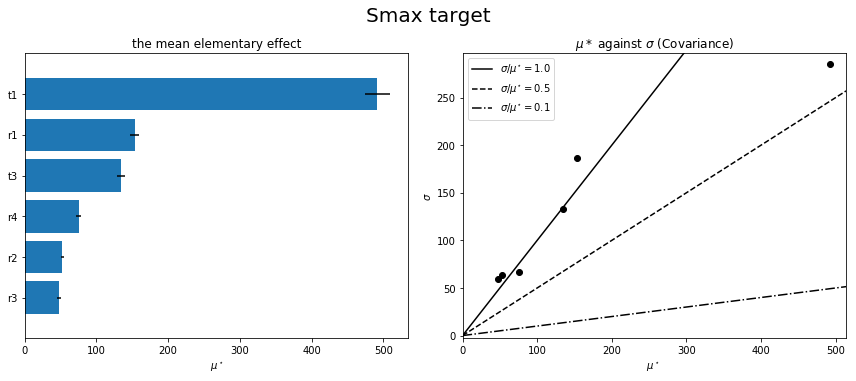

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5))
plt.suptitle('Smax target', fontsize=20, y=1.05)
horizontal_bar_plot(ax1, MI_smax,{}, sortby='mu_star')
covariance_plot(ax2, MI_smax, {})
ax1.set_title('the mean elementary effect')
ax2.set_title('$\mu*$ against $\sigma$ (Covariance)')
plt.tight_layout()
plt.show()

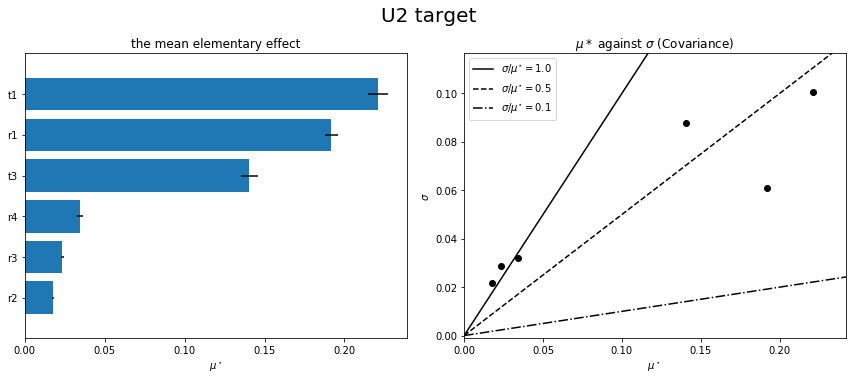

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5))
plt.suptitle('U2 target', fontsize=20, y=1.05)
horizontal_bar_plot(ax1, MI_u2,{}, sortby='mu_star')
covariance_plot(ax2, MI_u2, {})
ax1.set_title('the mean elementary effect')
ax2.set_title('$\mu*$ against $\sigma$ (Covariance)')
plt.tight_layout()
plt.show()

#END Solution

#### Conclusion:

Both methods have shown that in case of Mass function t1 and t3 variables have the most significant influence, for Smax - t1 has the most elementary effect and for U2 - t1, r1 and t3 are important variables.

<b>PS.</b> Covariance "heat" matrix indicates that there is now dependencies between variables (which is obvious from problem statement)

### Task 2.3 (4 pt.): Optimization

The final goal is to optimize the **mass** of the rotating disk. It will be done with scipy optimizer via approximation, provided by the surrogate model. We assume that surrogate model is of reasonable quality. The optimization problem for full parameter space is prepared for you.

The following optimization problem should be solved:

$$
{\rm mass} \rightarrow \min_x \\
\mbox{subject to} \quad S_{max}(x) \le 600 \\
\qquad \qquad U_2(x) \le 0.3
$$

Your tasks:

* Perform optimization by running the code below
* After performing sensitivity analysis you got the most influential features. Reestimate your models on the reduced feature space
* Change the optimization problem statement so that it usess only the selected variables
* Compare the optimal results for two formulations considered and make a conclusion

In [22]:
result = minimize(lambda x: reg_mass.predict(x.reshape(1, -1)),
                  [109.0, 32.0, 123.0, 154.0, 6.0, 198.0],
                  bounds=problem['bounds'],
                  constraints=[{'type': 'ineq',
                                'fun' : lambda x: 600 - reg_smax.predict(x.reshape(1, -1))
                               },
                               {'type': 'ineq',
                                'fun' : lambda x: 0.3 - reg_u2.predict(x.reshape(1, -1))
                               }])
print(result)

     fun: 14.559509812887978
     jac: array([-0.15144634,  4.24236965,  0.03256416,  0.28014183,  2.38012695,
       -0.63976574])
 message: 'Optimization terminated successfully.'
    nfev: 131
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([-1.7321    , -0.70328286,  0.05376441,  1.7321    , -1.45668568,
       -1.7321    ])


In [23]:
#BEGIN Solution
X_for_mass = X[['t1','t3']]
X_for_smax = np.array(X[['t1']]).reshape(100,-1)
X_for_u2 = X[['r1','t1','t3']]

reg_mass = mass_svr
reg_smax = smax_rr
reg_u2 = u2_gpr_1

reg_mass.fit(X_for_mass,y_mass)
reg_smax.fit(X_for_smax,y_smax)
reg_u2.fit(X_for_u2, y_u2)

score = cross_val_score(reg_mass, X_for_mass, y_mass, cv = k_fold, scoring='neg_mean_squared_error')
print ('Mass:', -score.mean().round(5),'+/-', score.std().round(3))
score = cross_val_score(reg_smax, X_for_smax, y_smax, cv = k_fold, scoring='neg_mean_squared_error')
print ('Smax:', -score.mean().round(5),'+/-', score.std().round(3))
score = cross_val_score(reg_u2, X_for_u2, y_u2, cv = k_fold, scoring='neg_mean_squared_error')
print ('  U2:', -score.mean().round(5),'+/-', score.std().round(3))

Results decreased a little bit, but it's ok)

In [28]:
ind_mass = [1,4]
ind_smax = [1]
ind_u2 = [0,1,4]

result = minimize(lambda x: reg_mass.predict(x[ind_mass].reshape(1, -1)),
                  [109.0, 32.0, 123.0, 154.0, 6.0, 198.0],
                  bounds=problem['bounds'],
                  constraints=[{'type': 'ineq',
                                'fun' : lambda x: 600 - reg_smax.predict(x[ind_smax].reshape(1,-1))
                               },
                               {'type': 'ineq',
                                'fun' : lambda x: 0.3 - reg_u2.predict(x[ind_u2].reshape(1, -1))
                               }])
print(result)

#END Solution

     fun: 14.01736346684631
     jac: array([0.        , 3.05267334, 0.        , 0.        , 3.37065887,
       0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([-1.7321    , -0.23380197,  1.7321    ,  1.7321    , -1.44381875,
        1.7321    ])


##### Conclusion:
We see that results are very close to each other, and moreover t1 and t3 in both optimal solutions are similar (t3, which are most important variable are almost the same) It indicates (probably) that everything is right and we found 'real' dependence of given function. 

<br/> <!--Intentionally left blank-->